In [1]:
import torch
import torch.nn as nn
import timm
from d2l import torch as d2l
from torch.utils.data import DataLoader
import torchvision
import os

save_dir = './保存模型/'

D:\Ananconda\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] 找不到指定的模块。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
'''def train(net, train_dl, test_dl, num_epochs, lr, device):
    #w的初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m)== nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            #xavier_uniform_使得随机的输入不会得到离谱的输出导致一开始爆掉
        net.apply(init_weights)
        print('training on', device)
        net.to(device)
        optimizer = torch.optim.AdamW([{'params': params_1x},
                                    {'params': model.fc.parameters(),
                                      'lr': lr*10}],
                                  lr=lr, weight_decay=2e-4)
        loss = nn.CrossEntropyLoss()
        timer, num_batches = d2l.Timer(), len(train_dl)
        for epoch in range(num_epochs):
            net.train()#告诉pytorch 需要计算梯度
            for i,(X, y)in enumerate(train_dl):
                timer.start()
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                l = loss(y_hat, y)
                l.backward()
                optimizer.step()
                #metric.add(l * X.shape[0])
                timer.stop()
                
                '''
'''pytorch中为什么要用 zero_grad() 将梯度清零

调用backward()函数之前都要将梯度清零，因为如果梯度不清零，pytorch中会将上次计算的梯度和本次计算的梯度累加。这样逻辑的好处是，当我们的硬件限制不能使用更大的bachsize时，使用多次计算较小的bachsize的梯度平均值来代替，更方便，坏处当然是每次都要清零梯度。
'''


'''optimizer.step()通常用在每个mini-batch之中，而scheduler.step()通常用在epoch里面,但是不绝对，可以根据具体的需求来做。只有用了optimizer.step()，模型才会更新，而scheduler.step()是对lr进行调整。通常我们有

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1)
model = net.train(model, loss_function, optimizer, scheduler, num_epochs = 100)

在scheduler的step_size表示scheduler.step()每调用step_size次，对应的学习率就会按照策略调整一次。所以如果scheduler.step()是放在mini-batch里面，那么step_size指的是经过这么多次迭代，学习率改变一次。'''
                

'optimizer.step()通常用在每个mini-batch之中，而scheduler.step()通常用在epoch里面,但是不绝对，可以根据具体的需求来做。只有用了optimizer.step()，模型才会更新，而scheduler.step()是对lr进行调整。通常我们有\n\noptimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)\nscheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1)\nmodel = net.train(model, loss_function, optimizer, scheduler, num_epochs = 100)\n\n在scheduler的step_size表示scheduler.step()每调用step_size次，对应的学习率就会按照策略调整一次。所以如果scheduler.step()是放在mini-batch里面，那么step_size指的是经过这么多次迭代，学习率改变一次。'

In [3]:
train_data=torchvision.datasets .ImageFolder (root='./fruits-360/Training',transform=torchvision.transforms.ToTensor() )
test_ds=torchvision.datasets .ImageFolder (root='./fruits-360/Test',transform=torchvision.transforms.ToTensor() )
print(train_data.classes)  #输出train_data里面的文件夹名称

#制作dataloader、即可迭代的数据装载器
batchsize = 64   #每次抓取的数据数量
train_iter = DataLoader(train_data,batch_size=batchsize,shuffle=True,num_workers=0)
test_iter = DataLoader(test_ds, batch_size=batchsize, shuffle=False, num_workers=0)
#如何获得读入的图片总数？

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
# 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
# BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [5]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
# 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    torch.save(net,os.path.join(save_dir,f'fruit net_best.pth'))
    print(f'Stored a new best model in {save_dir}')
    #提取方法torch.load('fruit net.pkl')
    #def restore_net():
           # net = torch.load('net.pkl').cuda()
           # prediction = net(x)

loss 0.030, train acc 0.999, test acc 0.948
1062.1 examples/sec on cuda:0
Stored a new best model in ./保存模型/


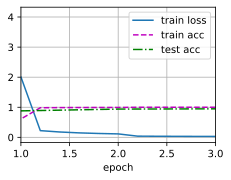

In [6]:
net = timm.create_model('resnet18', pretrained=True)
net.fc =  nn.Linear(net.fc.in_features, 131)
#种类131
lr, num_epochs, batch_size = 0.005, 3, 64
train(net,train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [7]:
import timm
model_list = timm.list_models()
print(model_list)

['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_224_in22k', 'beit_large_patch16_384', 'beit_large_patch16_512', 'botnet26t_256', 'botnet50ts_256', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_small', 'convnext_tiny', 'convnext_tiny_hnf', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'crossvit_9_240', 'crossvit_9_d